# Aug 22 - Atmosphere Sensitivity 

Scratch for testing sensitivity of 6S outputs to atmospheric parameters.

In [1]:
import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import rtm_wrapper.plot as rtm_plot
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation

In [2]:
wavelengths = np.arange(0.58, 0.6, 0.0025)
ozone_range = (0.25, 0.45)  # cm-atm
water_range = (1, 4)  # g/cm^2

|████████████████████████████████████████| 72/72 [100%] in 0.7s (92.63/s)       
|████████████████████████████████████████| 108/108 [100%] in 1.1s (99.48/s)     


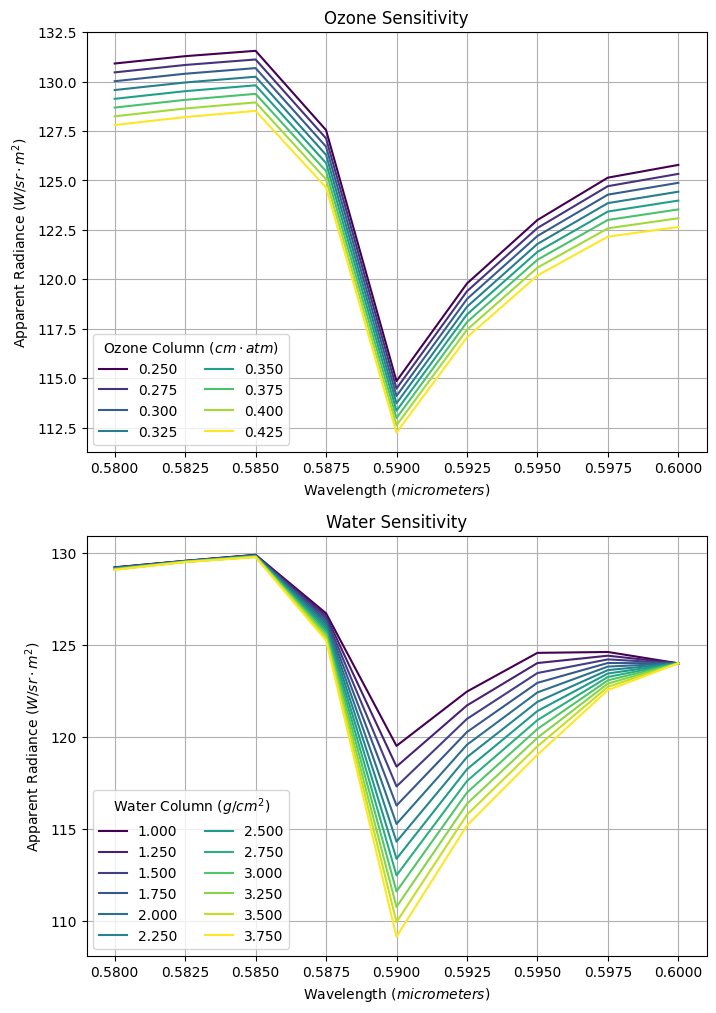

In [3]:
sweeps = {
    "ozone": SweepSimulation(
        {
            "wavelength.value": wavelengths,
            "atmosphere.ozone": np.arange(*ozone_range, 0.025),
        },
        base=pysixs_default_inputs().replace(
            atmosphere=rtm_param.AtmosphereWaterOzone(water=np.mean(water_range))
        ),
    ),
    "water": SweepSimulation(
        {
            "wavelength.value": wavelengths,
            "atmosphere.water": np.arange(*water_range, 0.25),
        },
        base=pysixs_default_inputs().replace(
            atmosphere=rtm_param.AtmosphereWaterOzone(ozone=np.mean(ozone_range))
        ),
    ),
}

engine = PySixSEngine()
runner = ConcurrentExecutor()

results = {}
for name, sweep in sweeps.items():
    with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
        runner.run(sweep, engine, step_callback=lambda _: bar())
    results[name] = runner.collect_results()


fig, axs = plt.subplots(nrows=len(results), figsize=(8, 12))

for (name, output), ax in zip(results.items(), axs.flat):
    ax.set_prop_cycle(
        color=plt.cm.viridis(np.linspace(0, 1, list(output.sizes.values())[-1]))
    )
    rtm_plot.plot_sweep_legend(
        output.apparent_radiance,
        ax=ax,
        xaxis_dim="wavelength.value",
        legend_kwargs={"loc": "lower left", "ncol": 2},
    )
    ax.set_title(f"{name.capitalize()} Sensitivity")
    ax.grid(True)